# SIR model

Here we calibrate a differentiable version of the SIR model.
We use the exact same model as  https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html,
but implemented in a differentiable way.

In [31]:
# from blackbirds.models.sir import SIR
from blackbirds.infer.vi import VI

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
import pygtc
from torch_geometric.utils import is_undirected

from sir_agents_torch_egonets_cal import SIR, simulate_and_observe_model
from loss import MMD

## Generating synthetic true data

In [32]:
device = "cpu"

In [33]:
# generate a random graph
n_agents = 100
k, p = 10, 0.1
graph = networkx.watts_strogatz_graph(n_agents, k, p, seed=0)

In [34]:
n_timesteps = 100
gamma, rho, initial_fraction_infected = 0.15, 0.15, 0.1
alpha1, alpha2, beta1, beta2 = 0.7, 0.7, 0.1, 0.1
model = SIR(graph, n_timesteps=n_timesteps, n_agents=n_agents, device=device)

In [35]:
# %%time
# the simulator takes as parameters the log10 of the fraction of initial cases, beta, and gamma parameters
true_contagion_parameters = torch.log10(torch.tensor([gamma, rho, initial_fraction_infected], device=device))
true_social_parameters = torch.log10(torch.tensor([alpha1, alpha2, beta1, beta2], device=device))
data = model(torch.cat([true_contagion_parameters, true_social_parameters]))
_, true_infected, true_recovered, true_states, true_ego_nets = data

In [36]:
# def map_states(states):
#     state_dict = {0: 'I', 1: 'S', 2: 'R'}  ## state S, I, R takes value of 1, 0, 2, respectively
#     return np.vectorize(state_dict.get)(states)

# true_states = map_states(true_states)

In [37]:
# def get_ego_nets(ego_nets_per_day, states_per_day, agent_sample):
#     G_per_day, y_per_day = [], []
#     for t in range(len(ego_nets_per_day)):
#         ego_nets, states = ego_nets_per_day[t], states_per_day[t]
#         G = []
#         curr = 0
#         for i in agent_sample:
#             node_ids = ego_nets.n_id[ego_nets.n_sub_batch == i]
#             ego_net = ego_nets.subgraph(node_ids)
#             g = torch_geometric.utils.to_networkx(ego_net, to_undirected=True)
#             networkx.set_node_attributes(g, {j: state for j, state in enumerate(states[node_ids])}, "state")
#             G.append(networkx.relabel_nodes(g, lambda x: x + curr))  # NOTE: relabel since node names need to be disjoint
#             curr += len(node_ids)
#         G = networkx.compose_all(G)
#         G_per_day.append(G)
#         # y_per_day.append(networkx.get_node_attributes(G, "state"))
#     return G_per_day

In [38]:
sample_ratio = 0.1
np.random.seed(0)
agent_sample = np.random.choice(n_agents, int(n_agents*sample_ratio), replace=False)
# agent_sample = np.arange(n_agents)
# true_ego_nets_subset = get_ego_nets(true_ego_nets, true_states, agent_sample)

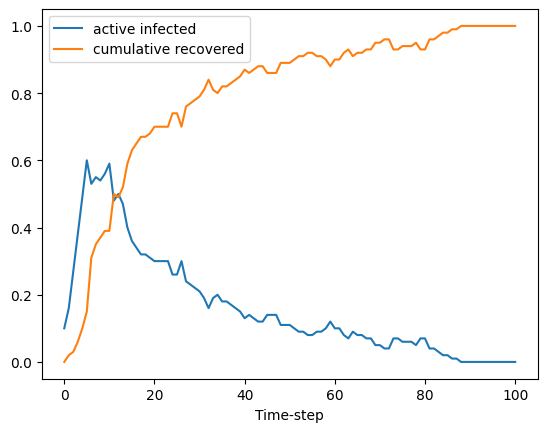

In [39]:
f, ax = plt.subplots()
ax.plot(true_infected.cpu(), label = "active infected")
ax.set_xlabel("Time-step")
ax.plot(true_recovered.cpu(), label = "cumulative recovered")
ax.legend()

In [40]:
print(model.graph)
print(is_undirected(model.graph.edge_index))
# model.reset_graph()
# print(model.graph)

Data(edge_index=[2, 794], num_nodes=100)
True


## Approximating the posterior by a normalizing flow

We construct the flow using the normflows library (https://github.com/VincentStimper/normalizing-flows )

In this case we define Neural Spline Flow with 4 transformations, each parametrised by 2 layers with 64 hidden units.

In [41]:
def make_flow(n_parameters, device):
    K = 16
    torch.manual_seed(0)
    flows = []
    for i in range(K):
        flows.append(nf.flows.MaskedAffineAutoregressive(n_parameters, 20, num_blocks=2))
        flows.append(nf.flows.Permute(n_parameters, mode="swap"))
    q0 = nf.distributions.DiagGaussian(n_parameters)
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)
    return nfm.to(device)

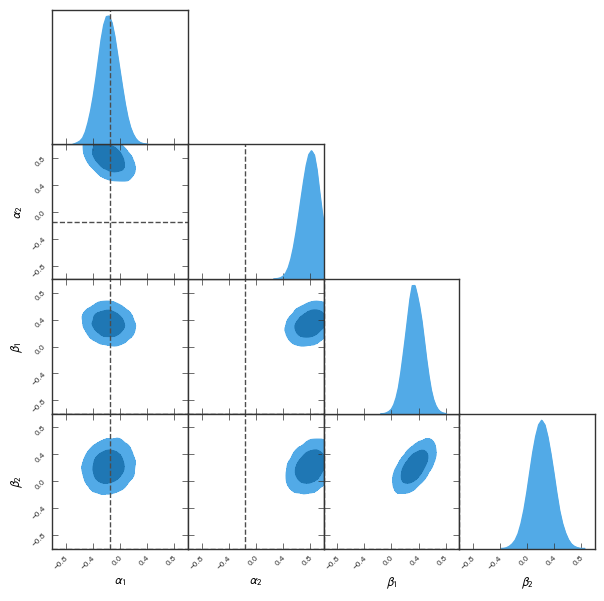

In [42]:
# Plot the inital flow:
flow = make_flow(len(true_social_parameters), device=device)
samples = flow.sample(10000)[0].cpu().detach().numpy()

pygtc.plotGTC([samples], truths=true_social_parameters.cpu().numpy(), figureSize=7,
              paramRanges=[(-1, 1) for i in range(4)],
              paramNames=[
                #   r"$\gamma$", r"$\rho$", r"$I_0$",
                  r"$\alpha_1$", r"$\alpha_2$", r"$\beta_1$", r"$\beta_2$"]);

Let's also plot runs sampled from the untrained flow, to compare later with the trained flow.

Data(edge_index=[2, 3276], num_nodes=100) tensor([-0.1615,  0.8856,  0.5435,  0.3367])
Data(edge_index=[2, 2144], num_nodes=100) tensor([-0.1142,  0.8146,  0.1153, -0.0941])
Data(edge_index=[2, 2102], num_nodes=100) tensor([0.0192, 0.6754, 0.2445, 0.0959])
Data(edge_index=[2, 1906], num_nodes=100) tensor([0.1092, 0.8127, 0.2638, 0.2502])
Data(edge_index=[2, 3074], num_nodes=100) tensor([-0.1330,  0.6982,  0.5817,  0.3330])
Data(edge_index=[2, 3312], num_nodes=100) tensor([-0.1982,  0.9255,  0.5049,  0.4954])
Data(edge_index=[2, 2308], num_nodes=100) tensor([-0.0158,  0.6223,  0.2772,  0.0254])
Data(edge_index=[2, 2730], num_nodes=100) tensor([-0.1776,  0.8539,  0.2772,  0.3741])
Data(edge_index=[2, 2936], num_nodes=100) tensor([-0.2894,  1.0579,  0.2328,  0.1343])
Data(edge_index=[2, 2704], num_nodes=100) tensor([-0.1992,  0.7898,  0.2405,  0.0707])
Data(edge_index=[2, 2724], num_nodes=100) tensor([-0.2113,  0.9660,  0.2573,  0.1231])
Data(edge_index=[2, 2302], num_nodes=100) tensor([-

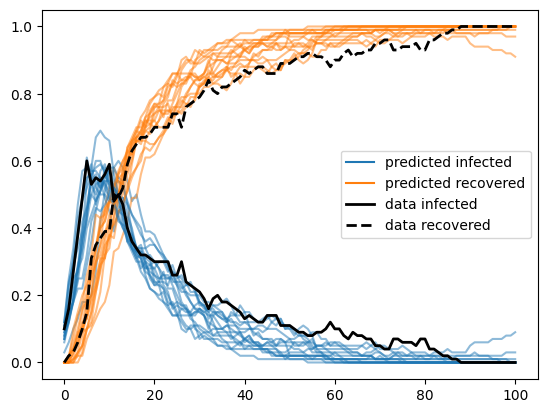

In [43]:
f, ax = plt.subplots()

for i in range(15):
    with torch.no_grad():
        model = SIR(graph, n_timesteps=n_timesteps, n_agents=n_agents, device=device)
        sim_params = flow.sample(1)[0][0]
        sim_sir = model(torch.cat([true_contagion_parameters, sim_params]))
    ax.plot(sim_sir[1].cpu().numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[2].cpu().numpy(), color = "C1", alpha=0.5)
    print(model.graph, sim_params)

ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(true_infected.cpu(), color = "black", linewidth=2, label = "data infected")
ax.plot(true_recovered.cpu(), color = "black", linewidth=2, label = "data recovered", linestyle="--")
ax.legend()

### Train the flow

In [14]:
torch.manual_seed(0)

class MMDLoss:
    def __init__(self, agent_sample):  # NOTE: agent_sample stores subset of agents' ids whose ego networks are used to compute loss
        self.loss_fn = MMD()
        self.agent_sample = agent_sample
        
    def __call__(self, params, data):
        model = SIR(graph, n_timesteps=n_timesteps, n_agents=n_agents, device=device)
        # params = torch.clip(params, min=-1, max=-0.05)
        loss = simulate_and_observe_model(model, torch.cat([true_contagion_parameters, params]), data, self.agent_sample, self.loss_fn)
        return loss

prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(4, device=device), torch.eye(4, device=device))
loss = MMDLoss(agent_sample=agent_sample)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
w = 0.1

vi = VI(loss = loss,
        posterior_estimator = flow,
        prior=prior,
        optimizer=optimizer,
        w=w,
        n_samples_per_epoch=10,
        log_tensorboard=True,
        device=device,
        gradient_estimation_method='score'  # NOTE: 'score' for non-differentiable models
       )

# and we run for 1000 epochs, stopping if the loss doesn't improve in 100 epochs.
vi.run(data, n_epochs=1000, max_epochs_without_improvement=50)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [05:44<31:50:24, 114.97s/it, loss=17, reg.=1.72, total=18.7, best loss=14.4, epochs since improv.=2] 


KeyboardInterrupt: 

<Axes: >

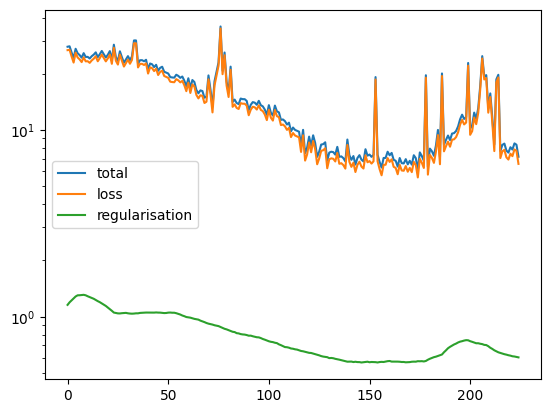

In [12]:
# Let's have a look at the loss over epochs:

df = pd.DataFrame(vi.losses_hist)
df.plot(logy=True)

In [13]:
# We can load the best model to check the results
flow.load_state_dict(vi.best_estimator_state_dict)

<All keys matched successfully>

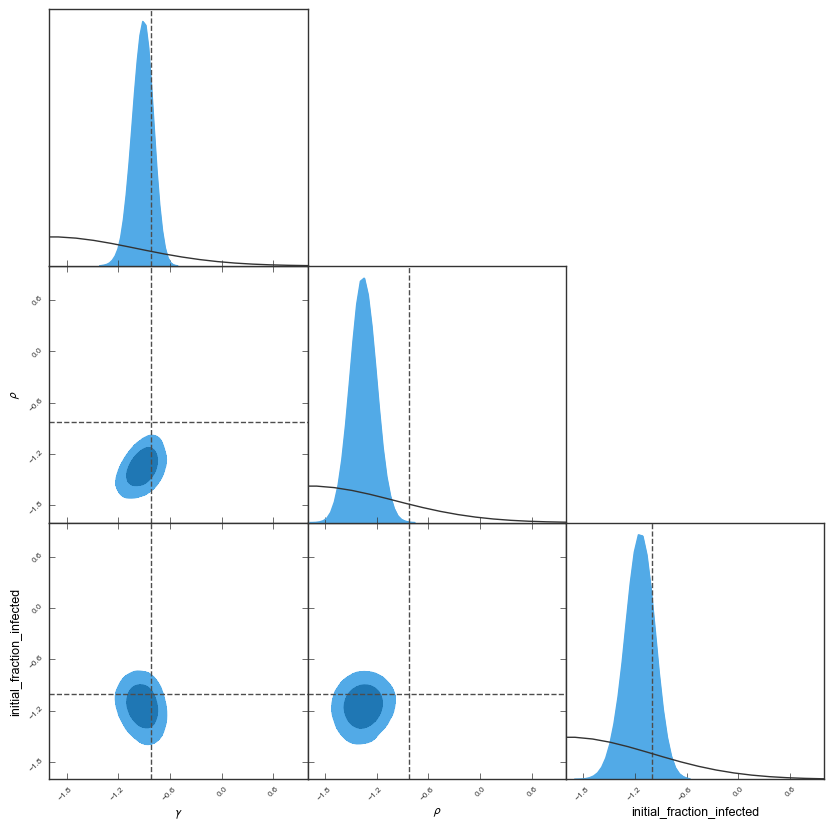

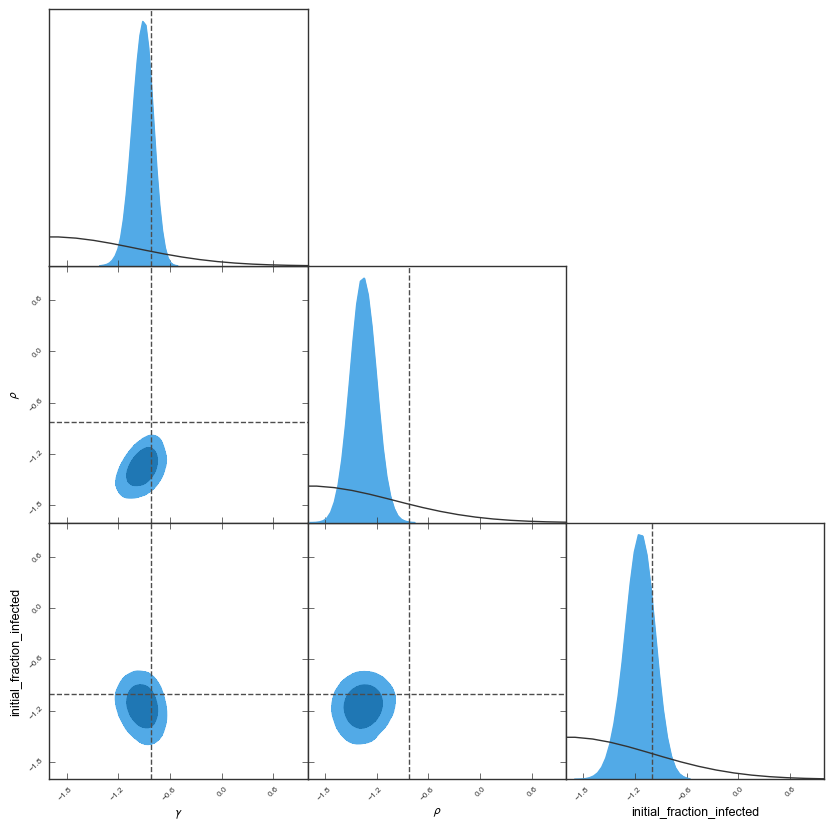

In [15]:
# Plot the final flow posterior approximator and compare it to the real parameters:
samples = flow.sample(50000)[0].cpu().detach().numpy()

pygtc.plotGTC([samples], truths=true_parameters.cpu().numpy(), figureSize=10, priors=[(-2, 1) for i in range(3)],
              paramRanges=[(-2, 1) for i in range(3)], paramNames=[r"$\gamma$", r"$\rho$", "initial_fraction_infected"]);

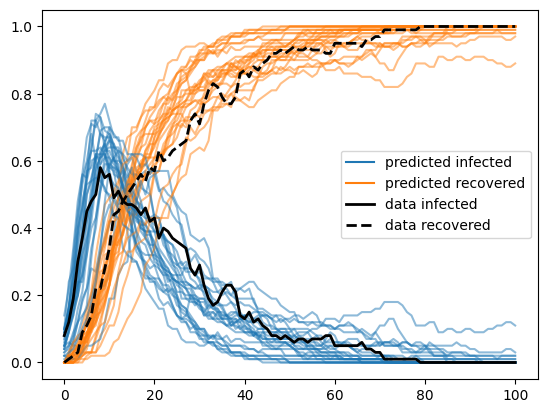

In [16]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(25):
    with torch.no_grad():
        sim_sir = model((flow.sample(1)[0][0]))
    ax.plot(sim_sir[1].cpu().numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[2].cpu().numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(true_infected.cpu(), color = "black", linewidth=2, label = "data infected")
ax.plot(true_recovered.cpu(), color = "black", linewidth=2, label = "data recovered", linestyle="--")

ax.legend()